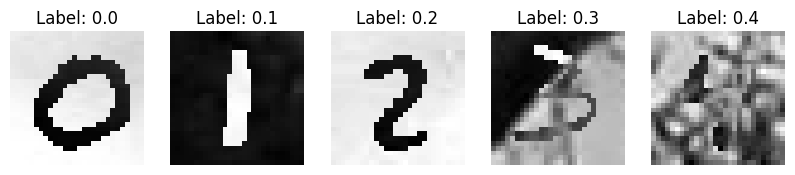

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%pip install seaborn
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
#%pip install opencv-python
import cv2

# 1. Carga y visualización de ejemplos de cada modalidad
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img = cv2.imread(os.path.join(subfolder_path, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    # Conservar el nombre '0.0' y eliminar 'png'
                    label = ".".join(filename.split('.')[:-1])
                    labels.append(label)
                else:
                    print(f'Error al cargar la imagen {filename}')
    return np.array(images), np.array(labels)

# Cambia el path a la carpeta donde descargaste el dataset PolyMNIST
train_folder_path = './MMNIST/train'
test_folder_path = './MMNIST/test'

train_images, train_labels = load_images_from_folder(train_folder_path)
test_images, test_labels = load_images_from_folder(test_folder_path)

# Visualizar algunos ejemplos de las modalidades
def show_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

show_samples(train_images, train_labels)



In [19]:
# Obtener estadísticas básicas
pixel_values = train_images.ravel()

print(f"Valor mínimo de píxel: {pixel_values.min()}")
print(f"Valor máximo de píxel: {pixel_values.max()}")
print(f"Valor medio de píxel: {pixel_values.mean()}")
print(f"Desviación estándar de píxel: {pixel_values.std()}")


Valor mínimo de píxel: 0
Valor máximo de píxel: 255
Valor medio de píxel: 110.1164056207483
Desviación estándar de píxel: 67.91179795996366


In [20]:
# Detección de imágenes que son completamente negras (o casi)
# Para imágenes en escala de grises, el array `train_images` tiene 3 dimensiones: (num_imagenes, altura, anchura)
black_images = np.sum(train_images == 0, axis=(1, 2)) == (train_images.shape[1] * train_images.shape[2])
num_black_images = np.sum(black_images)

print(f"Imágenes completamente negras: {num_black_images}")

# Visualizar algunas imágenes negras (si las hay)
if num_black_images > 0:
    show_samples(train_images[black_images], train_labels[black_images])


Imágenes completamente negras: 0


Verificando la existencia de la ruta: ./MMNIST/train\m0
La ruta ./MMNIST/train\m0 existe y es válida.
Verificando la existencia de la ruta: ./MMNIST/train\m1
La ruta ./MMNIST/train\m1 existe y es válida.
Verificando la existencia de la ruta: ./MMNIST/train\m2
La ruta ./MMNIST/train\m2 existe y es válida.
Verificando la existencia de la ruta: ./MMNIST/train\m3
La ruta ./MMNIST/train\m3 existe y es válida.
Verificando la existencia de la ruta: ./MMNIST/train\m4
La ruta ./MMNIST/train\m4 existe y es válida.
Carpeta m0: 60000 archivos encontrados.
Ejemplo de nombres de archivo en m0: ['0.0.png', '0.1.png', '0.2.png', '0.3.png', '0.4.png']
Imagen 0.0.png cargada correctamente.


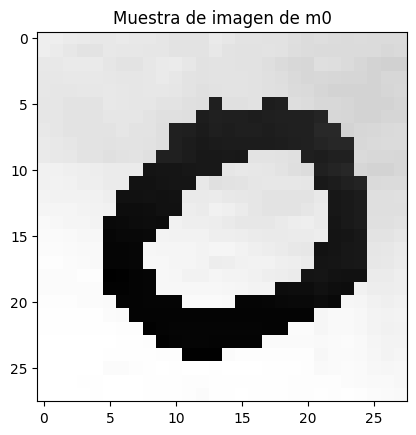

Carpeta m1: 60000 archivos encontrados.
Ejemplo de nombres de archivo en m1: ['0.0.png', '0.1.png', '0.2.png', '0.3.png', '0.4.png']
Imagen 0.0.png cargada correctamente.


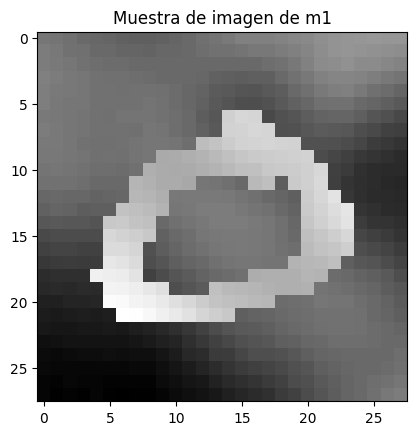

Carpeta m2: 60000 archivos encontrados.
Ejemplo de nombres de archivo en m2: ['0.0.png', '0.1.png', '0.2.png', '0.3.png', '0.4.png']
Imagen 0.0.png cargada correctamente.


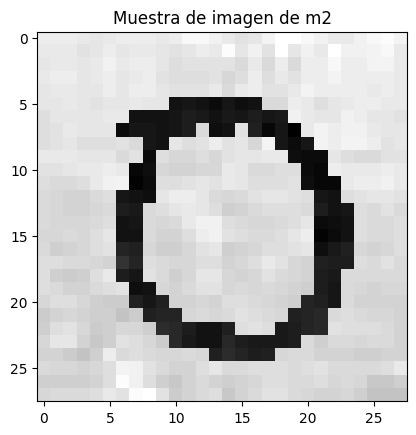

Carpeta m3: 60000 archivos encontrados.
Ejemplo de nombres de archivo en m3: ['0.0.png', '0.1.png', '0.2.png', '0.3.png', '0.4.png']
Imagen 0.0.png cargada correctamente.


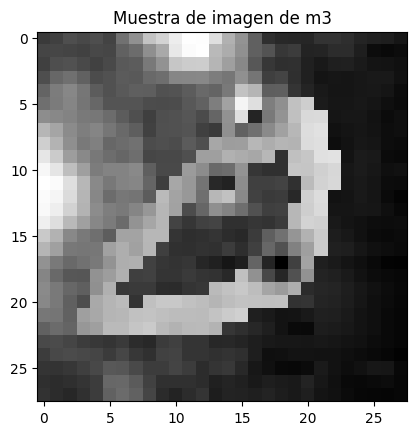

Carpeta m4: 60000 archivos encontrados.
Ejemplo de nombres de archivo en m4: ['0.0.png', '0.1.png', '0.2.png', '0.3.png', '0.4.png']
Imagen 0.0.png cargada correctamente.


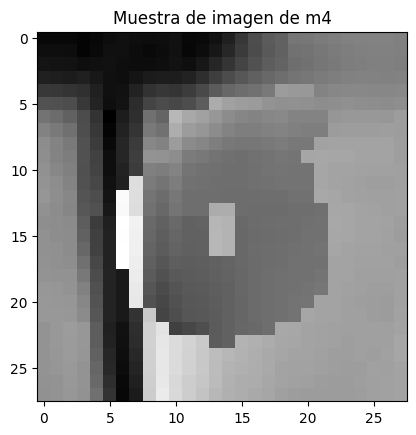

In [21]:
modalities = ['m0', 'm1', 'm2', 'm3', 'm4']
train_folder_path = './MMNIST/train'
test_folder_path = './MMNIST/test'

for modality in modalities:
    modality_path = os.path.join(train_folder_path, modality)
    print(f'Verificando la existencia de la ruta: {modality_path}')
    if not os.path.exists(modality_path):
        print(f'Error: la ruta {modality_path} no existe.')
    else:
        print(f'La ruta {modality_path} existe y es válida.')

# Verificación del contenido de las carpetas y carga manual de una imagen
for modality in modalities:
    modality_path = os.path.join(train_folder_path, modality)
    if os.path.exists(modality_path):
        files = os.listdir(modality_path)
        print(f'Carpeta {modality}: {len(files)} archivos encontrados.')
        if len(files) > 0:
            print(f'Ejemplo de nombres de archivo en {modality}: {files[:5]}')
            
            # Intentar cargar directamente una imagen
            sample_image_path = os.path.join(modality_path, files[0])
            sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
            if sample_image is not None:
                print(f'Imagen {files[0]} cargada correctamente.')
                plt.imshow(sample_image, cmap='gray')
                plt.title(f'Muestra de imagen de {modality}')
                plt.show()
            else:
                print(f'Error al cargar la imagen {files[0]}')
        else:
            print(f'La carpeta {modality} está vacía.')
    else:
        print(f'La carpeta {modality} no existe.')

In [22]:
# Intentar cargar todas las imágenes de cada modalidad
for modality in modalities:
    modality_path = os.path.join(train_folder_path, modality)
    modality_images, modality_labels = load_images_from_folder(modality_path)
    
    print(f'Modalidad {modality}:')
    print(f'Número de imágenes: {len(modality_images)}')
    print(f'Número de etiquetas: {len(modality_labels)}')
    
    if len(modality_labels) > 0:
        unique, counts = np.unique(modality_labels, return_counts=True)
        print(f'Distribución de las clases: {dict(zip(unique, counts))}')
        
        sns.countplot(modality_labels)
        plt.title(f'Distribución de las Clases en Modalidad {modality}')
        plt.show()
    else:
        print(f'No se cargaron etiquetas para la modalidad {modality}.')

Modalidad m0:
Número de imágenes: 0
Número de etiquetas: 0
No se cargaron etiquetas para la modalidad m0.
Modalidad m1:
Número de imágenes: 0
Número de etiquetas: 0
No se cargaron etiquetas para la modalidad m1.
Modalidad m2:
Número de imágenes: 0
Número de etiquetas: 0
No se cargaron etiquetas para la modalidad m2.
Modalidad m3:
Número de imágenes: 0
Número de etiquetas: 0
No se cargaron etiquetas para la modalidad m3.
Modalidad m4:
Número de imágenes: 0
Número de etiquetas: 0
No se cargaron etiquetas para la modalidad m4.


In [25]:
# 2. Análisis Exploratorio de Datos
# Distribución de las clases
sns.countplot(train_labels)
plt.title('Distribución de las Clases')
plt.show()

# Resolución de las imágenes
print(f"Resolución de las imágenes: {train_images[0].shape}")

# Verificación de si el dataset está balanceado
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Distribución de las clases: {dict(zip(unique, counts))}")


In [ ]:
# 3. Modelos de Deep Learning
# Normalización de las imágenes
train_images = train_images / 255.0
train_images = np.expand_dims(train_images, axis=-1)  # Añadir la dimensión de canal

test_images = test_images / 255.0
test_images = np.expand_dims(test_images, axis=-1)  # Añadir la dimensión de canal

# One-hot encoding de las etiquetas
train_labels_categorical = to_categorical(train_labels, num_classes=len(np.unique(train_labels)))
test_labels_categorical = to_categorical(test_labels, num_classes=len(np.unique(test_labels)))

# Modelo 1: CNN Simple
model_1 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(np.unique(train_labels)), activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo 1
history_1 = model_1.fit(train_images, train_labels_categorical, validation_data=(test_images, test_labels_categorical), epochs=10, batch_size=32)

# Evaluación del modelo 1
y_pred_1 = model_1.predict(test_images)
y_pred_1_classes = np.argmax(y_pred_1, axis=1)
y_true = np.argmax(test_labels_categorical, axis=1)

print("Modelo 1: Reporte de Clasificación")
print(classification_report(y_true, y_pred_1_classes))

# Modelo 2: CNN con Dropout y Batch Normalization
model_2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(train_images.shape[1], train_images.shape[2], 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(train_labels)), activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo 2
history_2 = model_2.fit(train_images, train_labels_categorical, validation_data=(test_images, test_labels_categorical), epochs=10, batch_size=32)

# Evaluación del modelo 2
y_pred_2 = model_2.predict(test_images)
y_pred_2_classes = np.argmax(y_pred_2, axis=1)

print("Modelo 2: Reporte de Clasificación")
print(classification_report(y_true, y_pred_2_classes))

# 4. Modelo de Red Neuronal Simple (sin convoluciones)
model_simple = Sequential([
    Flatten(input_shape=(train_images.shape[1], train_images.shape[2], 1)),
    Dense(128, activation='relu'),
    Dense(len(np.unique(train_labels)), activation='softmax')
])

model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo simple
history_simple = model_simple.fit(train_images, train_labels_categorical, validation_data=(test_images, test_labels_categorical), epochs=10, batch_size=32)

# Evaluación del modelo simple
y_pred_simple = model_simple.predict(test_images)
y_pred_simple_classes = np.argmax(y_pred_simple, axis=1)

print("Modelo Simple: Reporte de Clasificación")
print(classification_report(y_true, y_pred_simple_classes))

# Matrices de confusión para cada modelo
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true, y_pred_1_classes, "Matriz de Confusión Modelo 1")
plot_confusion_matrix(y_true, y_pred_2_classes, "Matriz de Confusión Modelo 2")
plot_confusion_matrix(y_true, y_pred_simple_classes, "Matriz de Confusión Modelo Simple")

ValueError: invalid literal for int() with base 10: '0.0'